In [17]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Jia_MSH2_SSM"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [18]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [19]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [20]:
scoreset

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,mavedb_clnsig,mavedb_clnrevstat,synonymous,nonsense
0,urn:mavedb:00000050-a-1#1,NaN,NaN,p.Met1Ala,-0.079522,NaN,NaN,False,False
1,urn:mavedb:00000050-a-1#3,NaN,NaN,p.Met1Tyr,-2.870684,NaN,NaN,False,False
2,urn:mavedb:00000050-a-1#4,NaN,NaN,p.Met1Trp,-3.991671,NaN,NaN,False,False
3,urn:mavedb:00000050-a-1#5,NaN,NaN,p.Met1Val,-1.395361,Uncertain_significance,reviewed_by_expert_panel,False,False
4,urn:mavedb:00000050-a-1#6,NaN,NaN,p.Met1Thr,0.301806,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...
16744,urn:mavedb:00000050-a-1#17742,NaN,NaN,p.Thr934Cys,-2.485740,NaN,NaN,False,False
16745,urn:mavedb:00000050-a-1#17743,NaN,NaN,p.Thr934Tyr,-4.022393,NaN,NaN,False,False
16746,urn:mavedb:00000050-a-1#17744,NaN,NaN,p.Thr934Ala,-3.004477,NaN,NaN,False,False
16747,urn:mavedb:00000050-a-1#17745,NaN,NaN,p.Thr934Lys,-4.976463,Conflicting_interpretations_of_pathogenicity,"criteria_provided,_conflicting_interpretations",False,False


In [21]:
if "author_transcript" not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [22]:
AUTHOR_TRANSCRIPT

'NM_000251'

# Add ClinVar annotations

In [23]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

100%|██████████| 3717/3717 [00:01<00:00, 1928.63it/s]


In [12]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [13]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [14]:
Ensembl_transcript_stable_ids

array(['ENST00000233146'], dtype=object)

In [15]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [16]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [17]:
scoreset_processed

,hgvs_pro,accession,hgvs_nt,hgvs_splice,score,mavedb_clnsig,mavedb_clnrevstat,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Met1Ala,urn:mavedb:00000050-a-1#1,NaN,NaN,-0.079522,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Met1Tyr,urn:mavedb:00000050-a-1#3,NaN,NaN,-2.870684,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p.Met1Trp,urn:mavedb:00000050-a-1#4,NaN,NaN,-3.991671,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p.Met1Val,urn:mavedb:00000050-a-1#5,NaN,NaN,-1.395361,Uncertain_significance,reviewed_by_expert_panel,False,False,0.0,0.0,0.0,1.0,NM_000251.3(MSH2):c.1A>G (p.Met1Val),1.0,0.0,NaN,NaN,NaN
4,p.Met1Thr,urn:mavedb:00000050-a-1#6,NaN,NaN,0.301806,NaN,NaN,False,False,0.0,0.0,0.0,1.0,NM_000251.3(MSH2):c.2T>C (p.Met1Thr),1.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16744,p.Thr934Cys,urn:mavedb:00000050-a-1#17742,NaN,NaN,-2.485740,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16745,p.Thr934Tyr,urn:mavedb:00000050-a-1#17743,NaN,NaN,-4.022393,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16746,p.Thr934Ala,urn:mavedb:00000050-a-1#17744,NaN,NaN,-3.004477,NaN,NaN,False,False,0.0,1.0,0.0,0.0,NM_000251.3(MSH2):c.2800A>G (p.Thr934Ala),1.0,0.0,6.855290e-07,0.0,2:47482944:A:G|2:47482944:A:G
16747,p.Thr934Lys,urn:mavedb:00000050-a-1#17745,NaN,NaN,-4.976463,Conflicting_interpretations_of_pathogenicity,"criteria_provided,_conflicting_interpretations",False,False,0.0,0.0,1.0,0.0,NM_000251.3(MSH2):c.2801C>A (p.Thr934Lys),1.0,0.0,3.771330e-05,0.0,2:47482945:C:A|2:47482945:C:A|2:47482945:C:A|2...


In [18]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [8]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [9]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [13]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = True
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [14]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 101
B/LB: 210
gnomAD: 1361


(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>], dtype=object))

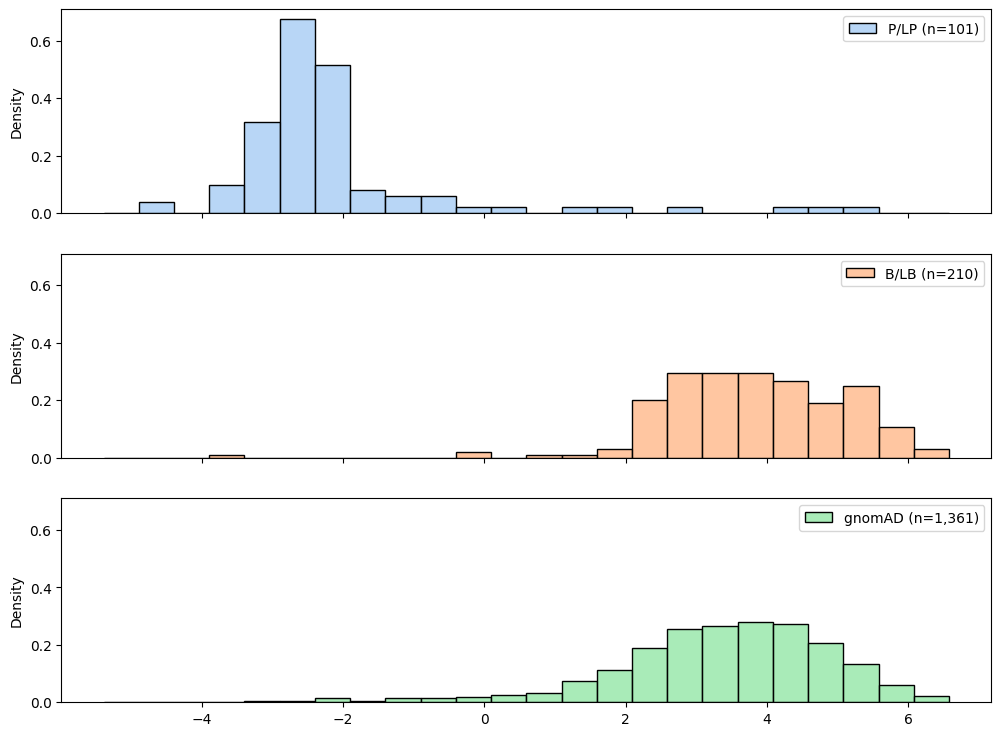

In [15]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [9]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)

In [10]:
old = joblib.load(dataset_path / "hgvs_pro.pkl")

In [28]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['p_lp'].values) - set(sample_data['P/LP'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Asp660Gly,1,0,0,0,NM_000251.3(MSH2):c.1979A>G (p.Asp660Gly),1,1.00
p.Gln314His,1,0,0,0,NM_000251.3(MSH2):c.942G>T (p.Gln314His),1,0.89
p.Glu452Val,1,0,0,0,NM_000251.3(MSH2):c.1355A>T (p.Glu452Val),1,0.98
p.Gly587Arg,1,0,0,0,NM_000251.3(MSH2):c.1759G>C (p.Gly587Arg),1,0.98
p.Gly587Cys,1,0,0,0,NM_000251.3(MSH2):c.1759G>T (p.Gly587Cys),1,0.97
p.Gly587Ser,1,0,0,0,NM_000251.3(MSH2):c.1759G>A (p.Gly587Ser),1,0.95
p.Gly71Arg,2,0,0,0,NM_000251.3(MSH2):c.211G>C (p.Gly71Arg)|NM_000...,2,0.65
p.Gly761Arg,1,0,1,0,NM_000251.3(MSH2):c.2281G>A (p.Gly761Arg)|NM_0...,2,0.29
p.His639Tyr,1,0,0,0,NM_000251.3(MSH2):c.1915C>T (p.His639Tyr),1,0.99


In [32]:
sample_data['P/LP'].loc[sample_data['P/LP'].score > 1]

,hgvs_pro,accession,hgvs_nt,hgvs_splice,score,mavedb_clnsig,mavedb_clnrevstat,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
8087,p.Met453Lys,urn:mavedb:00000050-a-1#8599,NaN,NaN,2.083822,Pathogenic,reviewed_by_expert_panel,False,False,1.0,0.0,0.0,0.0,NM_000251.3(MSH2):c.1358T>A (p.Met453Lys),1.0,0.01,NaN,NaN,NaN
10919,p.Val611Glu,urn:mavedb:00000050-a-1#11596,NaN,NaN,4.503038,Likely_pathogenic,"criteria_provided,_single_submitter",False,False,1.0,0.0,0.0,0.0,NM_000251.3(MSH2):c.1832T>A (p.Val611Glu),1.0,0.00,NaN,NaN,NaN
11664,p.Pro652His,urn:mavedb:00000050-a-1#12378,NaN,NaN,4.921305,Likely_pathogenic,reviewed_by_expert_panel,False,False,1.0,0.0,0.0,0.0,NM_000251.3(MSH2):c.1955C>A (p.Pro652His),1.0,0.00,NaN,NaN,NaN
12060,p.Gly674Ser,urn:mavedb:00000050-a-1#12791,NaN,NaN,1.324744,Likely_pathogenic,"criteria_provided,_single_submitter",False,False,1.0,0.0,0.0,0.0,NM_000251.3(MSH2):c.2020G>A (p.Gly674Ser),1.0,0.00,NaN,NaN,NaN
12314,p.Met688Val,urn:mavedb:00000050-a-1#13066,NaN,NaN,2.605460,NaN,NaN,False,False,1.0,0.0,0.0,0.0,NM_000251.3(MSH2):c.2062A>G (p.Met688Val),1.0,0.01,NaN,NaN,NaN
13192,p.Arg737Lys,urn:mavedb:00000050-a-1#13991,NaN,NaN,5.085638,NaN,NaN,False,False,1.0,0.0,0.0,0.0,NM_000251.3(MSH2):c.2210G>A (p.Arg737Lys),1.0,0.01,NaN,NaN,NaN
